# Всем доброго дня.
***
### Это мой третий учебный проект
### В нём я буду оптимизировать датасет, посвящённый отзывам к различным отелям сайта Booking.com с целью выяснения закономерностей и отклонений, а также повышение качества предсказаний рейтинга отелей.
### Мои задачи заключаются в следующем:
* Обработать данные
* По максимуму перевести строчные данные в числовые
* Создать новые признаки
* Повысить эффективность модели по предсказанию рейтинга отеля
#### Вперёд!

In [151]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


In [152]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [153]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [154]:
!pip install pycountry

In [155]:
import pandas as pd

In [156]:
# Читаем данные
hotels_train = pd.read_csv('https://dl.dropboxusercontent.com/s/nex7vvntrhfj9h0/hotels.csv?dl=0') # датасет для обучения
hotels_test = pd.read_csv('https://dl.dropboxusercontent.com/s/iq32luzkppvdcdc/hotels_test.csv?dl=0') # датасет для предсказания
sample_submission = pd.read_csv('https://dl.dropboxusercontent.com/s/p21w0pxlm1kavl4/submission.csv?dl=0') # самбмишн

In [157]:
hotels_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [158]:
hotels_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [159]:
sample_submission.head()

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596


In [160]:
hotels_train['sample'] = 1 # помечаем где у нас трейн
hotels_test['sample'] = 0 # помечаем где у нас тест
hotels_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

hotels = hotels_test.append(hotels_train, sort=False).reset_index(drop=True)

In [161]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

Для начала избавимся от дубликатов.

In [162]:
dupl_columns = list(hotels.columns)

dupl = hotels.duplicated(subset=dupl_columns)
h_duplicates = hotels[dupl]
print(f'Found duplicates:{h_duplicates.shape[0]}')

Found duplicates:336


Поскольку данная операция ухудшает финальную метрику, проводить я её не стану. Однако, на мой взгляд, она логически целесообразна.

In [163]:
#hotels = hotels.drop_duplicates(subset=dupl_columns)
print(f'Total: {hotels.shape[0]}')

Total: 515738


In [164]:
# Переводим дату во временной формат
hotels['review_date'] = pd.to_datetime(hotels['review_date'], format='%m/%d/%Y')

Сравним среднюю и медианную оценку отелей по версии гостей.

In [165]:
hotels['reviewer_score'].mean()

6.297671686011115

In [166]:
hotels['reviewer_score'].median()

7.9

Медиана выше среднего. Это говорит о том, что положительных отзывов гораздо больше, чем отрицательных.

In [167]:
# Узнаём общее число отелей
hotels['hotel_name'].value_counts().head(20)

Britannia International Hotel Canary Wharf           4789
Strand Palace Hotel                                  4256
Park Plaza Westminster Bridge London                 4169
Copthorne Tara Hotel London Kensington               3578
DoubleTree by Hilton Hotel London Tower of London    3212
Grand Royale London Hyde Park                        2958
Holiday Inn London Kensington                        2768
Hilton London Metropole                              2628
Millennium Gloucester Hotel London                   2565
Intercontinental London The O2                       2551
Park Grand Paddington Court                          2288
Hilton London Wembley                                2227
Park Plaza County Hall London                        2223
Blakemore Hyde Park                                  2178
Park Plaza London Riverbank                          2167
M by Montcalm Shoreditch London Tech City            2155
DoubleTree by Hilton London Docklands Riverside      2147
St James Court

Теперь я займусь именами отелей, а именно постараюсь найти самые часто встречающие слова в них и выяснить их влияние на оценку отеля.

In [168]:
hotels['hotel_name_n'] = hotels['hotel_name'].str.split()

In [169]:
name = hotels.explode('hotel_name_n')

In [170]:
515738/2

257869.0

Для данного датафрейма, 257869 является идеальным числом. На мой взгляд, если какое-то слово встречается в половине отзывов, а его наличие создаёт существенное изменение в оценке отеля, то создание такого признака будет максимально эффективным методом улучшения качества модели.

In [171]:
name['hotel_name_n'].value_counts().head(20)

Hotel         234378
London        137227
The            58053
Park           43929
Amsterdam      39868
Hilton         35490
by             24369
Plaza          23105
Paris          21792
Grand          18430
Inn            18416
Kensington     18280
Barcelona      17764
City           17659
Holiday        15874
DoubleTree     15248
Western        15025
Best           15025
tel            14940
H              14110
Name: hotel_name_n, dtype: int64

Проведём опыты с раличными словами, встречающимися с во многих названиях отелей и сравним сренюю оценку отзыва при их наличии и отсутствии.

In [172]:
search = ['Hotel']
hotels['Hotel'] = hotels['hotel_name'].apply(lambda x: 1 if any(i in x for i in search) else 0)
check_p = hotels[hotels['Hotel']==1]
check_n = hotels[hotels['Hotel']==0]
display(round(check_p['reviewer_score'].mean(), 2), round(check_n['reviewer_score'].mean(), 2))

6.26

6.33

In [173]:
search = ['London']
hotels['London'] = hotels['hotel_name'].apply(lambda x: 1 if any(i in x for i in search) else 0)
check_p = hotels[hotels['London']==1]
check_n = hotels[hotels['London']==0]
display(round(check_p['reviewer_score'].mean(), 2), round(check_n['reviewer_score'].mean(), 2))

6.31

6.29

In [174]:
search = ['The']
hotels['name_The'] = hotels['hotel_name'].apply(lambda x: 1 if any(i in x for i in search) else 0)
check_p = hotels[hotels['name_The']==1]
check_n = hotels[hotels['name_The']==0]
display(round(check_p['reviewer_score'].mean(), 2), round(check_n['reviewer_score'].mean(), 2))

6.45

6.28

In [175]:
search = ['Park']
hotels['Park'] = hotels['hotel_name'].apply(lambda x: 1 if any(i in x for i in search) else 0)
check_p = hotels[hotels['Park']==1]
check_n = hotels[hotels['Park']==0]
display(round(check_p['reviewer_score'].mean(), 2), round(check_n['reviewer_score'].mean(), 2))

6.12

6.31

In [176]:
search = ['Amsterdam']
hotels['Amsterdam'] = hotels['hotel_name'].apply(lambda x: 1 if any(i in x for i in search) else 0)
check_p = hotels[hotels['Amsterdam']==1]
check_n = hotels[hotels['Amsterdam']==0]
display(round(check_p['reviewer_score'].mean(), 2), round(check_n['reviewer_score'].mean(), 2))

6.3

6.3

Избавляемся от признаков, которые практически никак не влияют на оценку гостя, а также от базового признака. 

In [177]:
hotels = hotels.drop('hotel_name', axis=1)
hotels = hotels.drop('Hotel', axis=1)
hotels = hotels.drop('London', axis=1)
hotels = hotels.drop('name_The', axis=1)
hotels = hotels.drop('Park', axis=1)
hotels = hotels.drop('Amsterdam', axis=1)

In [178]:
# Узнаём дату первого отзыва
hotels['review_date'].min()

Timestamp('2015-08-04 00:00:00')

In [179]:
# Узнаём дату последнего отзыва
hotels['review_date'].max()

Timestamp('2017-08-03 00:00:00')

Проведём те же самые манипуляции с положительными и отрицательными отзывами.

In [180]:
hotels['good_rev_n'] = hotels['positive_review'].str.split()

In [181]:
good = hotels.explode('good_rev_n')

In [182]:
good['good_rev_n'].value_counts().head(20)

and         416696
the         350102
was         235044
to          187269
The         164273
a           156570
staff       154145
very        151210
location    138293
room        123504
hotel       111808
in          111740
of          106494
is          102091
were         90675
for          89835
good         84737
helpful      72954
friendly     72417
with         65443
Name: good_rev_n, dtype: int64

In [183]:
search = ['the']
hotels['p_the'] = hotels['positive_review'].apply(lambda x: 1 if any(i in x for i in search) else 0)
check_p = hotels[hotels['p_the']==1]
check_n = hotels[hotels['p_the']==0]
display(round(check_p['reviewer_score'].mean(), 2), round(check_n['reviewer_score'].mean(), 2))

6.56

6.15

In [184]:
search = ['was']
hotels['p_was'] = hotels['positive_review'].apply(lambda x: 1 if any(i in x for i in search) else 0)
check_p = hotels[hotels['p_was']==1]
check_n = hotels[hotels['p_was']==0]
display(round(check_p['reviewer_score'].mean(), 2), round(check_n['reviewer_score'].mean(), 2))

6.49

6.22

In [185]:
search = ['to']
hotels['p_to'] = hotels['positive_review'].apply(lambda x: 1 if any(i in x for i in search) else 0)
check_p = hotels[hotels['p_to']==1]
check_n = hotels[hotels['p_to']==0]
display(round(check_p['reviewer_score'].mean(), 2), round(check_n['reviewer_score'].mean(), 2))

6.57

6.19

In [186]:
search = ['The']
hotels['p_The'] = hotels['positive_review'].apply(lambda x: 1 if any(i in x for i in search) else 0)
check_p = hotels[hotels['p_The']==1]
check_n = hotels[hotels['p_The']==0]
display(round(check_p['reviewer_score'].mean(), 2), round(check_n['reviewer_score'].mean(), 2))

6.46

6.25

In [187]:
search = ['staff']
hotels['p_staff'] = hotels['positive_review'].apply(lambda x: 1 if any(i in x for i in search) else 0)
check_p = hotels[hotels['p_staff']==1]
check_n = hotels[hotels['p_staff']==0]
display(round(check_p['reviewer_score'].mean(), 2), round(check_n['reviewer_score'].mean(), 2))

6.72

6.13

In [188]:
search = ['very']
hotels['p_very'] = hotels['positive_review'].apply(lambda x: 1 if any(i in x for i in search) else 0)
check_p = hotels[hotels['p_very']==1]
check_n = hotels[hotels['p_very']==0]
display(round(check_p['reviewer_score'].mean(), 2), round(check_n['reviewer_score'].mean(), 2))

6.71

6.14

In [189]:
search = ['location']
hotels['p_location'] = hotels['positive_review'].apply(lambda x: 1 if any(i in x for i in search) else 0)
check_p = hotels[hotels['p_location']==1]
check_n = hotels[hotels['p_location']==0]
display(round(check_p['reviewer_score'].mean(), 2), round(check_n['reviewer_score'].mean(), 2))

6.45

6.24

In [190]:
search = ['room']
hotels['p_room'] = hotels['positive_review'].apply(lambda x: 1 if any(i in x for i in search) else 0)
check_p = hotels[hotels['p_room']==1]
check_n = hotels[hotels['p_room']==0]
display(round(check_p['reviewer_score'].mean(), 2), round(check_n['reviewer_score'].mean(), 2))

6.62

6.17

In [191]:
search = ['hotel']
hotels['p_hotel'] = hotels['positive_review'].apply(lambda x: 1 if any(i in x for i in search) else 0)
check_p = hotels[hotels['p_hotel']==1]
check_n = hotels[hotels['p_hotel']==0]
display(round(check_p['reviewer_score'].mean(), 2), round(check_n['reviewer_score'].mean(), 2))

6.7

6.21

In [192]:
hotels = hotels.drop('positive_review', axis=1)

In [193]:
hotels['bad_rev_n'] = hotels['negative_review'].str.split()

In [194]:
bad = hotels.explode('bad_rev_n')

In [195]:
bad['bad_rev_n'].value_counts().head(20)

the         423240
was         234097
to          227172
a           219587
and         215427
in          164076
room        155018
No          154106
Negative    127907
of          120184
for         114282
not         112716
I           111948
The         106894
it           88774
is           81738
we           73629
t            72247
but          70515
very         69279
Name: bad_rev_n, dtype: int64

In [196]:
search = ['the']
hotels['n_the'] = hotels['negative_review'].apply(lambda x: 1 if any(i in x for i in search) else 0)
check_p = hotels[hotels['n_the']==1]
check_n = hotels[hotels['n_the']==0]
display(round(check_p['reviewer_score'].mean(), 2), round(check_n['reviewer_score'].mean(), 2))

5.83

6.58

In [197]:
search = ['was']
hotels['n_was'] = hotels['negative_review'].apply(lambda x: 1 if any(i in x for i in search) else 0)
check_p = hotels[hotels['n_was']==1]
check_n = hotels[hotels['n_was']==0]
display(round(check_p['reviewer_score'].mean(), 2), round(check_n['reviewer_score'].mean(), 2))

5.81

6.48

In [198]:
search = ['to']
hotels['n_to'] = hotels['negative_review'].apply(lambda x: 1 if any(i in x for i in search) else 0)
check_p = hotels[hotels['n_to']==1]
check_n = hotels[hotels['n_to']==0]
display(round(check_p['reviewer_score'].mean(), 2), round(check_n['reviewer_score'].mean(), 2))

5.79

6.52

In [199]:
search = ['a']
hotels['n_a'] = hotels['negative_review'].apply(lambda x: 1 if any(i in x for i in search) else 0)
check_p = hotels[hotels['n_a']==1]
check_n = hotels[hotels['n_a']==0]
display(round(check_p['reviewer_score'].mean(), 2), round(check_n['reviewer_score'].mean(), 2))

6.25

6.76

In [200]:
search = ['and']
hotels['n_and'] = hotels['negative_review'].apply(lambda x: 1 if any(i in x for i in search) else 0)
check_p = hotels[hotels['n_and']==1]
check_n = hotels[hotels['n_and']==0]
display(round(check_p['reviewer_score'].mean(), 2), round(check_n['reviewer_score'].mean(), 2))

5.59

6.55

In [201]:
search = ['in']
hotels['n_in'] = hotels['negative_review'].apply(lambda x: 1 if any(i in x for i in search) else 0)
check_p = hotels[hotels['n_in']==1]
check_n = hotels[hotels['n_in']==0]
display(round(check_p['reviewer_score'].mean(), 2), round(check_n['reviewer_score'].mean(), 2))

6.02

6.59

In [202]:
search = ['room']
hotels['n_room'] = hotels['negative_review'].apply(lambda x: 1 if any(i in x for i in search) else 0)
check_p = hotels[hotels['n_room']==1]
check_n = hotels[hotels['n_room']==0]
display(round(check_p['reviewer_score'].mean(), 2), round(check_n['reviewer_score'].mean(), 2))

5.6

6.56

In [203]:
search = ['No']
hotels['n_No'] = hotels['negative_review'].apply(lambda x: 1 if any(i in x for i in search) else 0)
check_p = hotels[hotels['n_No']==1]
check_n = hotels[hotels['n_No']==0]
display(round(check_p['reviewer_score'].mean(), 2), round(check_n['reviewer_score'].mean(), 2))

6.77

6.0

In [204]:
search = ['Negative']
hotels['n_Negative'] = hotels['negative_review'].apply(lambda x: 1 if any(i in x for i in search) else 0)
check_p = hotels[hotels['n_Negative']==1]
check_n = hotels[hotels['n_Negative']==0]
display(round(check_p['reviewer_score'].mean(), 2), round(check_n['reviewer_score'].mean(), 2))

7.0

6.07

In [205]:
hotels = hotels.drop('negative_review', axis=1)

Теперь проведём те же самые манипуляции с тегами.

In [206]:
def rev_func(num_tags):
    num_tags = num_tags[2:-2]
    res = num_tags.strip().split(' \', \' ')
    return res

hotels['tags_n'] = hotels['tags'].apply(rev_func)

In [207]:
tags = hotels.explode('tags_n')
display(f'Total number of tags: {len(tags["tags_n"].unique())}')

'Total number of tags: 2428'

In [208]:
tags['tags_n'].value_counts().head(10)

Leisure trip                      417778
Submitted from a mobile device    307640
Couple                            252294
Stayed 1 night                    193645
Stayed 2 nights                   133937
Solo traveler                     108545
Stayed 3 nights                    95821
Business trip                      82939
Group                              65392
Family with young children         61015
Name: tags_n, dtype: int64

In [209]:
search = ['Leisure trip']
hotels['leisure_trip'] = hotels['tags_n'].apply(lambda x: 1 if any(i in x for i in search) else 0)
check_p = hotels[hotels['leisure_trip']==1]
check_n = hotels[hotels['leisure_trip']==0]
display(round(check_p['reviewer_score'].mean(), 2), round(check_n['reviewer_score'].mean(), 2))

6.37

5.98

In [210]:
search = ['Submitted from a mobile device']
hotels['mobile'] = hotels['tags_n'].apply(lambda x: 1 if any(i in x for i in search) else 0)
check_p = hotels[hotels['mobile']==1]
check_n = hotels[hotels['mobile']==0]
display(round(check_p['reviewer_score'].mean(), 2), round(check_n['reviewer_score'].mean(), 2))

6.31

6.27

In [211]:
search = ['Couple']
hotels['couple'] = hotels['tags_n'].apply(lambda x: 1 if any(i in x for i in search) else 0)
check_p = hotels[hotels['couple']==1]
check_n = hotels[hotels['couple']==0]
display(round(check_p['reviewer_score'].mean(), 2), round(check_n['reviewer_score'].mean(), 2))

6.39

6.21

In [212]:
search = ['Stayed 1 night']
hotels['one_night'] = hotels['tags_n'].apply(lambda x: 1 if any(i in x for i in search) else 0)
check_p = hotels[hotels['one_night']==1]
check_n = hotels[hotels['one_night']==0]
display(round(check_p['reviewer_score'].mean(), 2), round(check_n['reviewer_score'].mean(), 2))

6.31

6.29

In [213]:
search = ['Stayed 2 nights']
hotels['two_nights'] = hotels['tags_n'].apply(lambda x: 1 if any(i in x for i in search) else 0)
check_p = hotels[hotels['two_nights']==1]
check_n = hotels[hotels['two_nights']==0]
display(round(check_p['reviewer_score'].mean(), 2), round(check_n['reviewer_score'].mean(), 2))

6.28

6.3

In [214]:
search = ['Stayed 3 nights']
hotels['three_nights'] = hotels['tags_n'].apply(lambda x: 1 if any(i in x for i in search) else 0)
check_p = hotels[hotels['three_nights']==1]
check_n = hotels[hotels['three_nights']==0]
display(round(check_p['reviewer_score'].mean(), 2), round(check_n['reviewer_score'].mean(), 2))

6.34

6.29

In [215]:
search = ['Business trip']
hotels['business_trip'] = hotels['tags_n'].apply(lambda x: 1 if any(i in x for i in search) else 0)
check_p = hotels[hotels['business_trip']==1]
check_n = hotels[hotels['business_trip']==0]
display(round(check_p['reviewer_score'].mean(), 2), round(check_n['reviewer_score'].mean(), 2))

5.96

6.36

In [216]:
hotels = hotels.drop('tags', axis=1)
hotels = hotels.drop('one_night', axis=1)
hotels = hotels.drop('two_nights', axis=1)
hotels = hotels.drop('three_nights', axis=1)

Далее я решил провести закономерность между национальностью гостя отеля, оставившего отзыв с его оценкой.

In [217]:
# Приведём названия стран к стандартному коду для построения карты средней оценки отзыва

import numpy as np
import pycountry

def do_fuzzy_search(country):
    try:
        result = pycountry.countries.search_fuzzy(country)
    except Exception:
        return np.nan
    else:
        return result[0].alpha_3

iso_map = {country: do_fuzzy_search(country) for country in hotels["reviewer_nationality"].unique()}
hotels["country_code"] = hotels['reviewer_nationality'].map(iso_map)

In [218]:
# Заметим, что некоторые названия стран написаны не в соответствии со стандартом ISO.
miss = hotels[hotels['country_code'].isnull()]
miss['reviewer_nationality'].value_counts()

 Abkhazia Georgia                     153
 Macau                                109
 Palestinian Territory                 54
 Cura ao                               41
 Ivory Coast                           19
 U S Virgin Islands                    17
 Turks Caicos Islands                  14
 Antigua Barbuda                       14
 St Maarten                            11
 Laos                                   9
 Democratic Republic of the Congo       9
 Swaziland                              8
 Falkland Islands Malvinas              6
 Crimea                                 6
 East Timor                             4
 Bonaire St Eustatius and Saba          3
 Saint Barts                            3
 Central Africa Republic                3
 Saint Vincent Grenadines               2
 St Pierre and Miquelon                 2
 Cocos K I                              2
 Cape Verde                             1
 Svalbard Jan Mayen                     1
Name: reviewer_nationality, dtype:

In [219]:
# Переименуем такие названия
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].str.replace(r'Abkhazia Georgia', 'Georgia', regex= True)
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].str.replace(r'Macau', 'Macao', regex= True)
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].str.replace(r'Cura ao', 'Curaçao', regex= True)
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].str.replace(r'Palestinian Territory', 'Palestine, State of', regex= True)
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].str.replace(r'Ivory Coast', "Côte d'Ivoire", regex= True)
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].str.replace(r'Turks Caicos Islands', 'Turks and Caicos Islands', regex= True)
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].str.replace(r'Antigua Barbuda', 'Antigua and Barbuda', regex= True)
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].str.replace(r'Laos', "Lao People's Democratic Republic", regex= True)
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].str.replace(r'Democratic Republic of the Congo', 'Congo, the Democratic Republic of the', regex= True)
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].str.replace(r'Central Africa Republic', "Central African Republic", regex= True)
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].str.replace(r'U S Virgin Islands', 'Virgin Islands, U.S.', regex= True)
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].str.replace(r'Swaziland', 'SZ', regex= True)
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].str.replace(r'St Maarten', 'Sint Maarten (Dutch part)', regex= True)
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].str.replace(r'Falkland Islands Malvinas', 'Falkland Islands (Malvinas)', regex= True)
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].str.replace(r'East Timor', 'Timor-Leste', regex= True)
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].str.replace(r'St Pierre and Miquelon', 'Saint Pierre and Miquelon', regex= True)
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].str.replace(r'Cocos K I', 'Cocos (Keeling) Islands', regex= True)
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].str.replace(r'Bonaire St Eustatius and Saba', 'Bonaire, Sint Eustatius and Saba', regex= True)
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].str.replace(r'Svalbard Jan Mayen', 'Svalbard and Jan Mayen', regex= True)
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].str.replace(r'Saint Barts', 'Saint Barthélemy', regex= True)
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].str.replace(r'Saint Vincent Grenadines', 'Saint Vincent and the Grenadines', regex= True)
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].str.replace(r'Crimea', 'Ukraine', regex= True)
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].str.replace(r'Cape Verde', 'CV', regex= True)

In [220]:
# Проделаем преобразование ещё раз
iso_map = {country: do_fuzzy_search(country) for country in hotels["reviewer_nationality"].unique()}
hotels["country_code"] = hotels['reviewer_nationality'].map(iso_map)

In [221]:
# Строим карту количества отзывов в разных странах
import plotly
import plotly.express as px
choropleth_data = hotels.groupby('country_code')['reviewer_score'].count()
fig = px.choropleth(
    data_frame=choropleth_data,
    locations=choropleth_data.index,
    locationmode = 'ISO-3',
    color='reviewer_score',
    range_color=[1, 10000], 
    title='Number of Reviews in Different Countries', 
    width=1100, 
    height=700, 
    color_continuous_scale=[[0, 'rgb(255,255,255)'], [1, 'rgb(0,0,255)']]
)

fig.show()

Здесь, на мой взгляд существенную роль играют население страны и его благосостояние.

In [222]:
# Строим карту средней оценки отелей в зависимости от национальности гостя
import plotly
import plotly.express as px
choropleth_data = hotels.groupby('country_code')['reviewer_score'].median()
fig = px.choropleth(
    data_frame=choropleth_data,
    locations=choropleth_data.index,
    locationmode = 'ISO-3',
    color='reviewer_score',
    range_color=[7, 9], 
    title='Average Score from Guests in Different Countries', 
    width=1100, 
    height=700, 
    color_continuous_scale=[[0, 'rgb(255,0,0)'], [1, 'rgb(0,255,0)']]
)

fig.show()

В целом, каких-либо аномальностей я не обнаружил. В разных частях света разные средние оценки. Слишком явных перекосов не наблюдается.

In [223]:
# Избавимся от ненужного столбца
hotels = hotels.drop('reviewer_nationality', axis=1)

Далее распределим отели по их стране нахождения.

In [224]:
# Выбираем последнее слово из адреса отеля
hotels['hotel_country'] = hotels['hotel_address'].str.split().str[-1]

In [225]:
hotels['hotel_country'].value_counts()

Kingdom        262301
Spain           60149
France          59928
Netherlands     57214
Austria         38939
Italy           37207
Name: hotel_country, dtype: int64

In [226]:
# Меняем название на номерной код страны согласно формату ISO
hotels['hotel_country'] = hotels['hotel_country'].str.replace(r'Kingdom', '826', regex= True)
hotels['hotel_country'] = hotels['hotel_country'].str.replace(r'Spain', '724', regex= True)
hotels['hotel_country'] = hotels['hotel_country'].str.replace(r'France', '250', regex= True)
hotels['hotel_country'] = hotels['hotel_country'].str.replace(r'Netherlands', '528', regex= True)
hotels['hotel_country'] = hotels['hotel_country'].str.replace(r'Austria', '040', regex= True)
hotels['hotel_country'] = hotels['hotel_country'].str.replace(r'Italy', '380', regex= True)
hotels['hotel_country'] = hotels['hotel_country'].astype(int)

In [227]:
# Для построения карты добавляем буквенный код страны
hotels['hotel_country_code'] = hotels['hotel_country'].astype(str)
hotels['hotel_country_code'] = hotels['hotel_country_code'].str.replace(r'826', 'GBR', regex= True)
hotels['hotel_country_code'] = hotels['hotel_country_code'].str.replace(r'724', 'ESP', regex= True)
hotels['hotel_country_code'] = hotels['hotel_country_code'].str.replace(r'250', 'FRA', regex= True)
hotels['hotel_country_code'] = hotels['hotel_country_code'].str.replace(r'528', 'NLD', regex= True)
hotels['hotel_country_code'] = hotels['hotel_country_code'].str.replace(r'40', 'AUT', regex= True)
hotels['hotel_country_code'] = hotels['hotel_country_code'].str.replace(r'380', 'ITA', regex= True)

In [228]:
# Строим карту средней оценки отелей в разных странах
choropleth_data2 = hotels.groupby('hotel_country_code')['reviewer_score'].median()
fig = px.choropleth(
    data_frame=choropleth_data2,
    locations=choropleth_data2.index,
    locationmode = 'ISO-3',
    color='reviewer_score',
    range_color=[7.9, 8.3], 
    title='Number of Hotels', 
    width=1100, 
    height=700, 
    color_continuous_scale=[[0, 'rgb(255,0,0)'], [1, 'rgb(0,255,0)']]
)

fig.show()

В целом, разница в оценках не сильно велика, однако заметно, что испанские отели пользуются большей популярностью, нежели чем британские.

In [229]:
# Удаляем ненужный признак
hotels = hotels.drop('hotel_address', axis=1)

Далее построим различные графики согласно дат отзывов

Text(0.5, 1.0, 'Количество отзывов согласно дате')

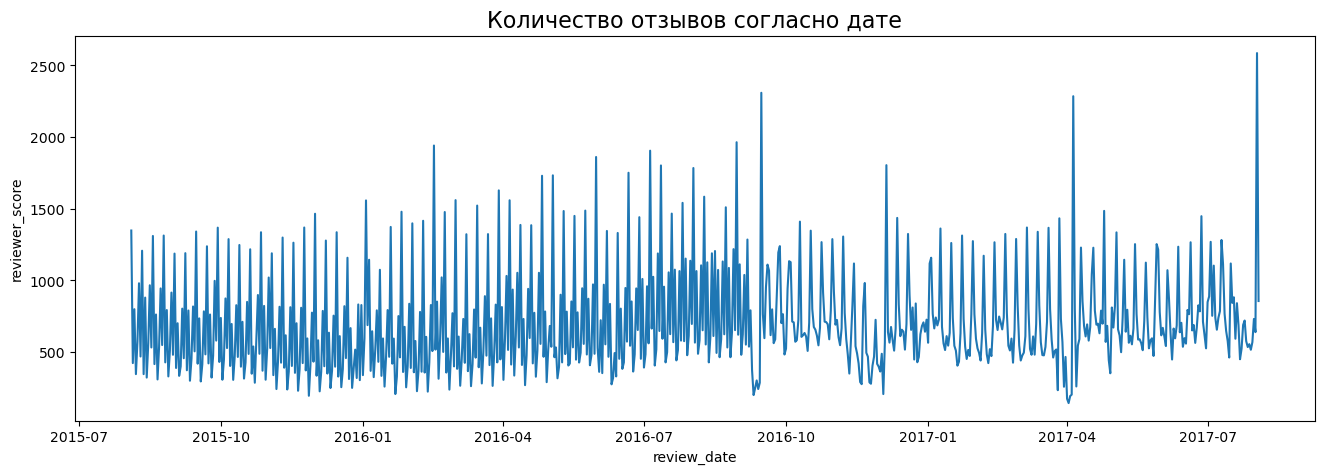

In [230]:
import matplotlib.pyplot as plt
import seaborn as sns

date = hotels.groupby('review_date')['reviewer_score'].count()
line,ax = plt.subplots(figsize=(16, 5)) 
ax = sns.lineplot(data=date)
ax.set_title('Количество отзывов согласно дате', fontsize=16)

В целом график относительно ровный, сложно обнаружить какие-либо отклонения.

Text(0.5, 1.0, 'Распределение средней оценки отзыва согласно дате')

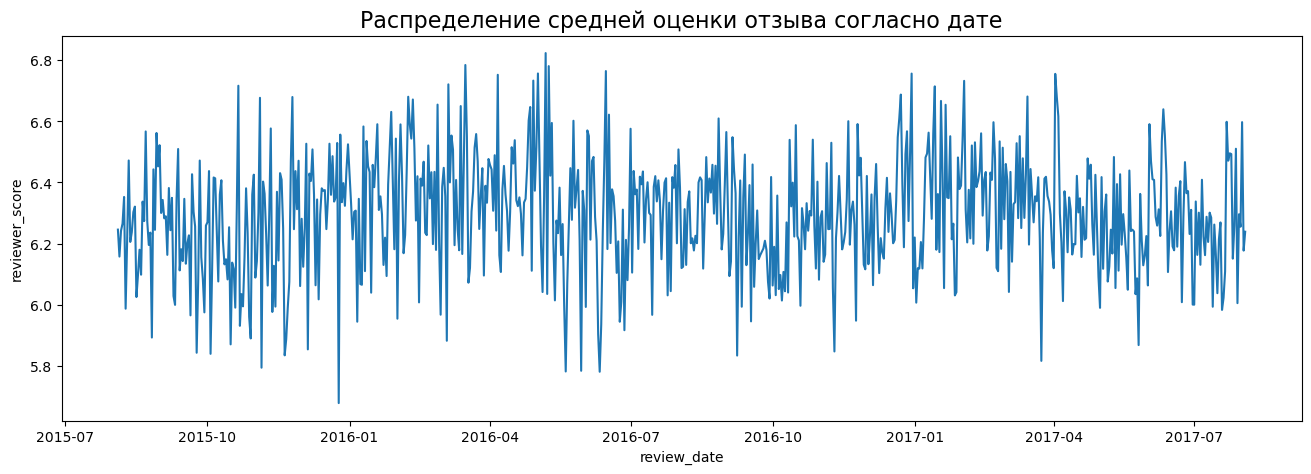

In [231]:
date2 = hotels.groupby('review_date')['reviewer_score'].mean()
line,ax = plt.subplots(figsize=(16, 5)) 
ax = sns.lineplot(data=date2)
ax.set_title('Распределение средней оценки отзыва согласно дате', fontsize=16)

Данный график тоже относительно ровный. Наблюдается т.н. "сезонность". Почему-то рейтинг отзывов, оставленных осенью заметно ниже отзывов, оставленных весной.

Text(0.5, 1.0, 'Распределение количества отзывов согласно оценкам')

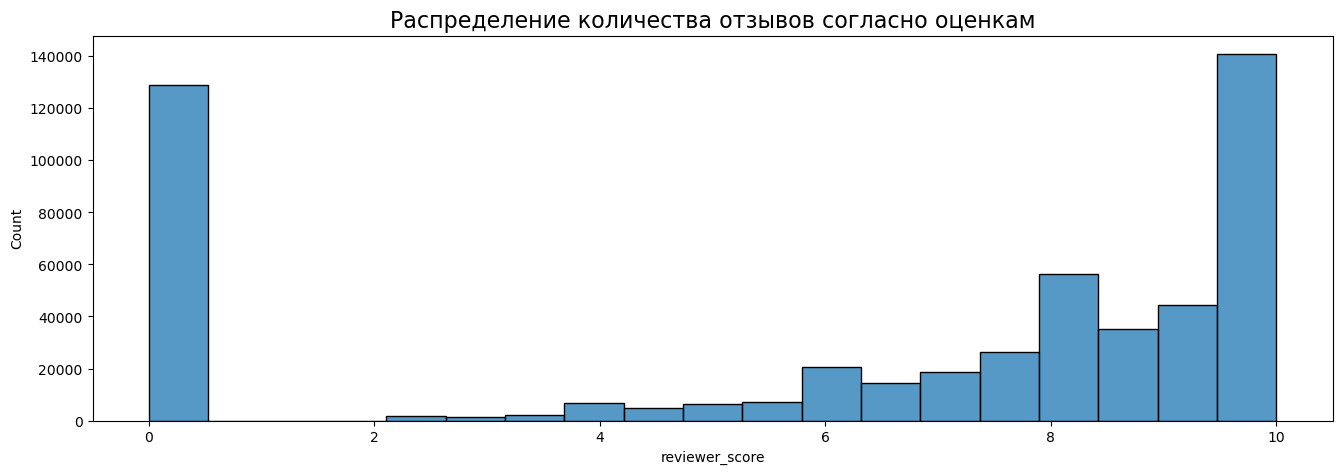

In [232]:
line,ax = plt.subplots(figsize=(16, 5)) 
ax = sns.histplot(data=hotels,x='reviewer_score', bins=19)
ax.set_title('Распределение количества отзывов согласно оценкам', fontsize=16)

Как и ожидалось, большинство гостей остафили своим отелям положительные отзывы.

Создадим ещё один числовой признак, а именно код страны гостя, оставившего отзыв отелю.

In [233]:
country = pd.read_csv('https://dl.dropboxusercontent.com/s/8i48ytvw634fvmk/country-codes.csv?dl=0')

In [234]:
# Оставляем два стобца с буквенным и числовым кодом страны согласно стандарту ISO
country = country.drop(columns=country.iloc[:, 6:]) 
country = country.drop(columns=country.iloc[:, 3:5])
country = country.drop(columns=country.iloc[:, 0:2]) 
country.head()

,ISO3166-1-Alpha-3,ISO3166-1-numeric
0,TWN,158.0
1,AFG,4.0
2,ALB,8.0
3,DZA,12.0
4,ASM,16.0


In [235]:
# Добавим данную таблицу к нашей
hotels = hotels.merge(country, left_on='country_code', right_on='ISO3166-1-Alpha-3', how='left')

In [236]:
hotels['ISO3166-1-numeric'] = hotels['ISO3166-1-numeric'].astype(int)

In [237]:
hotels = hotels.rename(columns={'ISO3166-1-Alpha-3': 'reviewer_country_code', 'ISO3166-1-numeric': 'reviewer_country_numeric_code'})

In [238]:
hotels['review_date'] = pd.to_datetime(hotels['review_date'], format='%Y%m%d').dt.strftime('%Y%m%d')

Создаём признак года отзыва

In [239]:
hotels['review_year'] = hotels['review_date'].apply(lambda x: x[:4])

Преобразуем признак даты и года к числовому формату

In [240]:
hotels['review_date'] = hotels['review_date'].astype(int)
hotels['review_year'] = hotels['review_year'].astype(int)

Теперь нам необходимо заполнить пропуски в данных

In [241]:
# Выясняем, в каких странах больше всего пропусков
nulls = hotels[hotels.isna().any(axis=1)]
nulls['hotel_country_code'].value_counts()

AUT    2679
FRA     382
ESP     207
Name: hotel_country_code, dtype: int64

In [242]:
# Заполняем пропуски средним значение широты и долготы отелей из той же страны
hotels['lat'] = hotels['lat'].fillna(hotels.groupby('hotel_country_code')['lat'].transform('median'))
hotels['lng'] = hotels['lng'].fillna(hotels.groupby('hotel_country_code')['lng'].transform('median'))

In [243]:
hotels['days_since_review'] = hotels['days_since_review'].str.split().str[0]
hotels['days_since_review']

0          13
1         234
2         616
3         656
4         444
         ... 
515733    106
515734    171
515735    543
515736     74
515737    363
Name: days_since_review, Length: 515738, dtype: object

In [244]:
hotels['days_since_review'] = hotels['days_since_review'].astype(int)

In [245]:
# Удаляем ненужные признаки
hotels = hotels.drop('total_number_of_reviews', axis=1)
hotels = hotels.drop('hotel_country', axis=1)
hotels = hotels.drop('review_date', axis=1)
hotels = hotels.drop('additional_number_of_scoring', axis=1)

<AxesSubplot:>

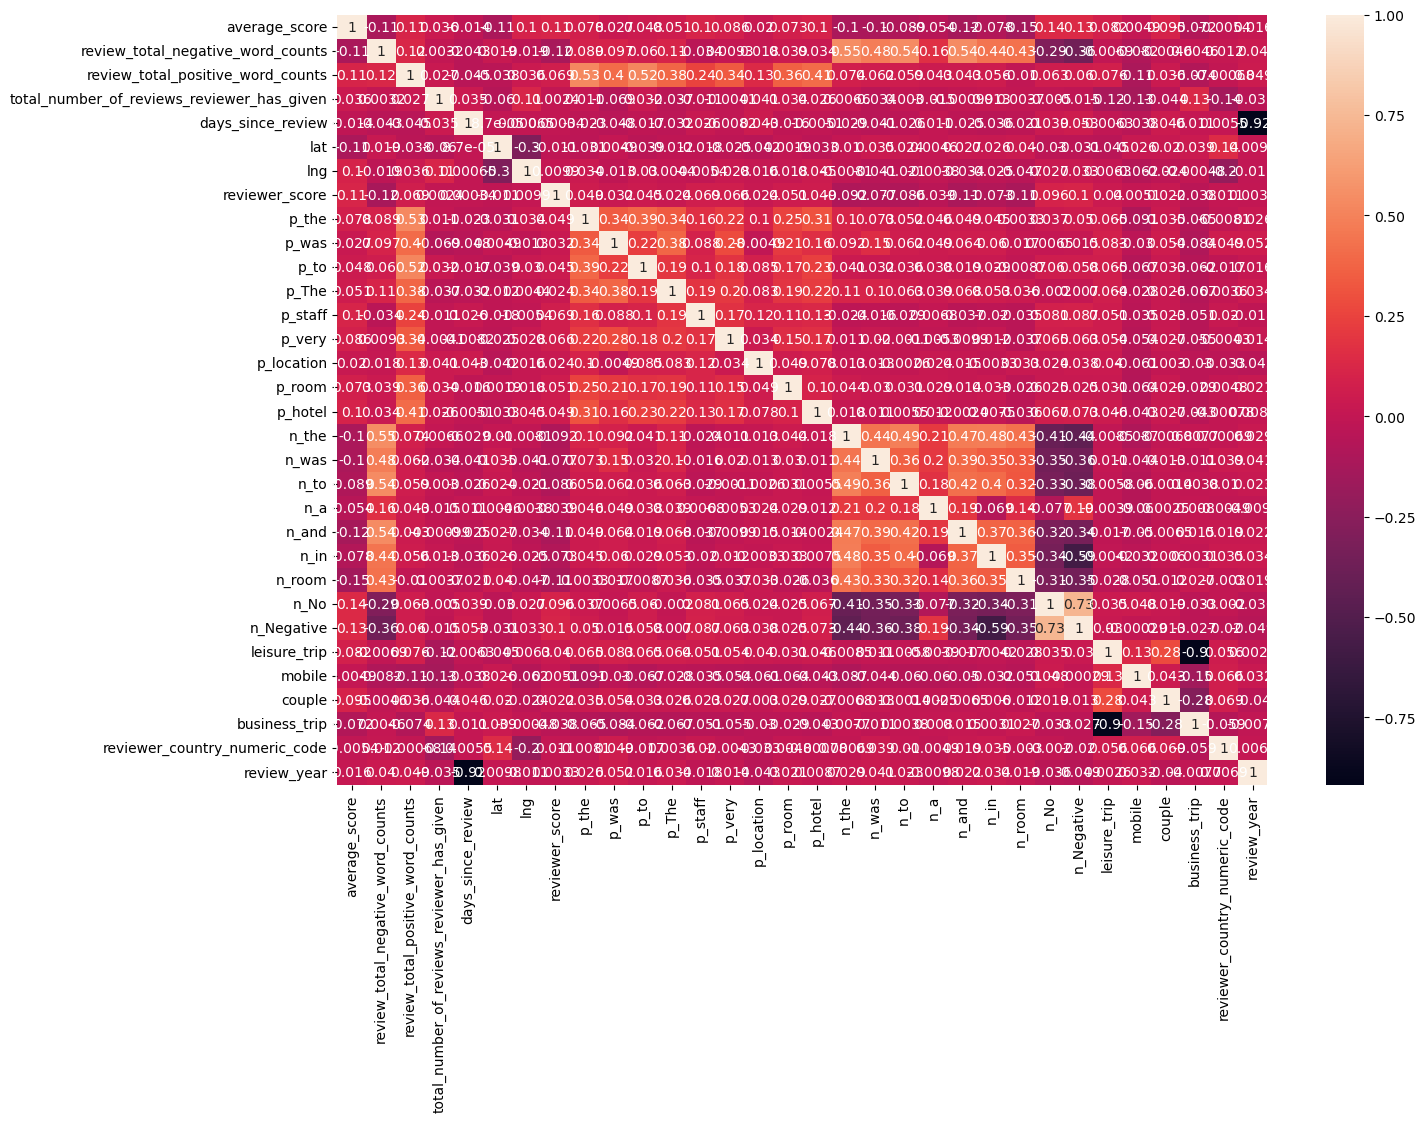

In [247]:
# строим график корреляции, какова связь между признаками

plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(hotels.drop(['sample'], axis=1).corr(), annot=True)

In [249]:
# убираем признаки которые еще не успели обработать, 
# модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
object_columns = [s for s in hotels.columns if hotels[s].dtypes == 'object']
hotels.drop(object_columns, axis = 1, inplace=True)

In [250]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 515737
Data columns (total 33 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   average_score                               515738 non-null  float64
 1   review_total_negative_word_counts           515738 non-null  int64  
 2   review_total_positive_word_counts           515738 non-null  int64  
 3   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 4   days_since_review                           515738 non-null  int64  
 5   lat                                         515738 non-null  float64
 6   lng                                         515738 non-null  float64
 7   sample                                      515738 non-null  int64  
 8   reviewer_score                              515738 non-null  float64
 9   p_the                                       515738 non-null  int64  
 

In [251]:
# Теперь выделим тестовую часть
train_data = hotels.query('sample == 1').drop(['sample'], axis=1)
test_data = hotels.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [252]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [253]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 32), (386803, 32), (386803, 31), (309442, 31), (77361, 31))

In [254]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [255]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [256]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   48.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.3s finished


In [257]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAPE:', metrics.mean_absolute_error(y_test, y_pred))

MAPE: 0.9052956072365733


<AxesSubplot:>

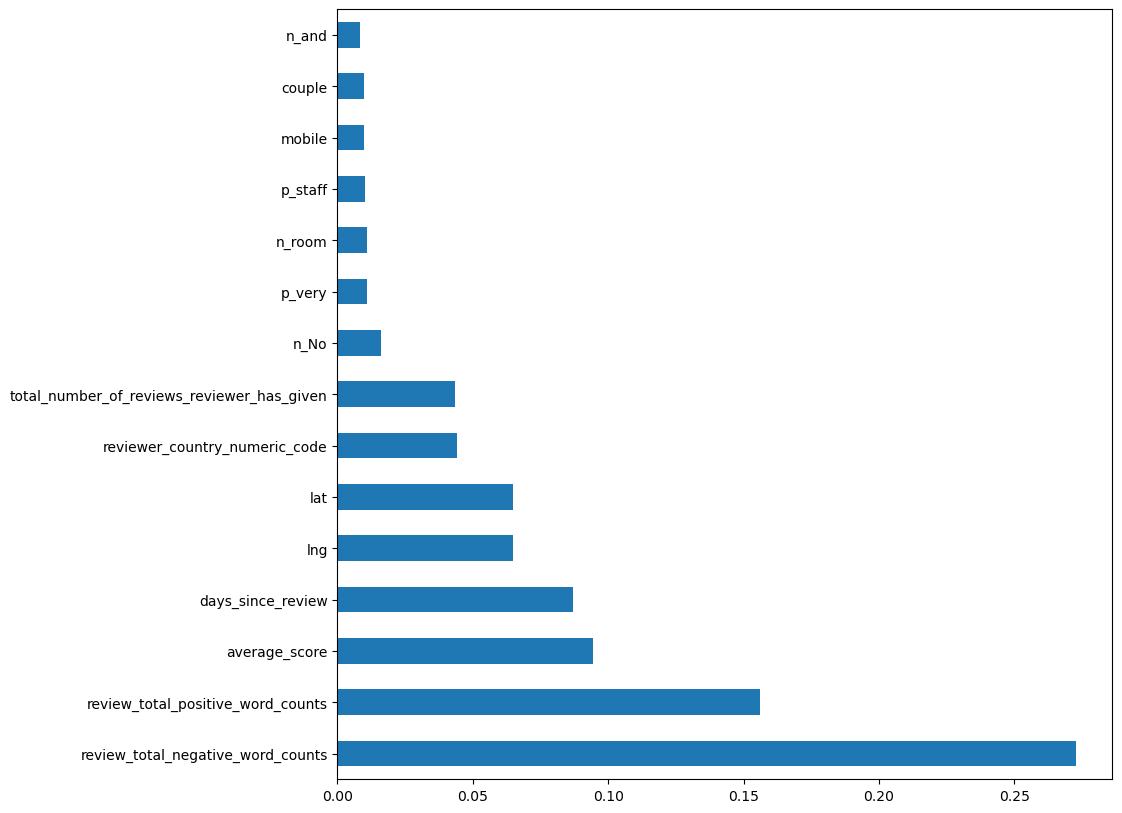

In [258]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [259]:
test_data.sample(10)

,average_score,review_total_negative_word_counts,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,lat,lng,reviewer_score,p_the,p_was,...,n_in,n_room,n_No,n_Negative,leisure_trip,mobile,couple,business_trip,reviewer_country_numeric_code,review_year
54401,8.7,6,12,1,235,52.354665,4.913164,0.0,1,0,...,1,0,1,0,0,1,0,1,826,2016
42044,8.1,0,14,7,436,45.477091,9.205421,0.0,0,1,...,0,0,1,1,1,1,0,0,360,2016
27732,8.2,27,2,29,160,48.869140,2.298102,0.0,0,0,...,1,1,1,0,0,0,1,1,250,2017
47699,8.7,28,0,6,627,51.513931,-0.121989,0.0,0,0,...,1,1,1,0,1,0,0,0,826,2015
51718,8.1,2,4,13,26,51.521759,-0.142538,0.0,0,0,...,0,0,0,0,0,0,0,1,826,2017
80783,7.3,66,0,2,417,51.515367,-0.178327,0.0,0,0,...,1,1,0,0,1,0,0,0,72,2016
100466,8.7,40,5,3,308,51.500961,-0.116591,0.0,0,0,...,1,1,0,0,0,0,0,1,826,2016
32314,8.0,21,45,1,204,48.193523,16.366915,0.0,1,1,...,1,1,1,0,1,0,0,0,616,2017
13160,8.7,10,17,4,261,48.839323,2.389227,0.0,1,0,...,0,0,0,0,1,1,1,0,528,2016
7606,8.1,20,16,3,292,51.499046,-0.191707,0.0,1,0,...,1,1,0,0,1,1,1,0,372,2016


In [260]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [261]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [262]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.7s finished


In [263]:
predict_submission

array([8.925, 6.867, 8.058, ..., 7.178, 9.572, 6.904])

In [264]:
list(sample_submission)

['reviewer_score', 'id']

In [265]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.925,488440
1,6.867,274649
2,8.058,374688
3,9.485,404352
4,9.407,451596
5,8.629,302161
6,8.362,317079
7,7.052,13963
8,8.282,159785
9,8.404,195089


# Общий вывод по проекту

***
### В данной работе я провёл работу по оптимизации датасета и выявлении оптимальных признаков для повышения качества предсказаний рейтинга отелей. В целом, можно сделать заключение, что на финальную оценку отеля влияют следующие принаки:
* Наличие или отсутствие слов, часто встречающиеся в положительных или отрицательных отзывах
* Некоторые часто встречающиеся тэги
* Национальность гостя, оставившего отзыв (как ни странно)
* Количество отзывов, оставленных гостем в прошлом
### При этом также можно отметить, что на финальную оценку практически никак не влияют такие признаки, как:
* Страна находжения отеля
* Слова, встречающиеся в имени отеля
* Дата оставленного отзыва
* Число оценок без проверки

### Подводя итоги, можно провести заключение:
| Задача                                     | Статус          |
|:-------------------------------------------|:---------------:|
| Обработка данных                           | **Выполнено**   |
| Перевод строчных признаков в числовые      | **Выполнено**   |
| Создание новых признаков                   | **Выполнено**   |
| Повышение эффективности модели предсказания| **Выполнено**   |

## Спасибо за просмотр!
***